In [1]:
import scanpy as sc

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import muon
import cellrank
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/moscot_up/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

['default', 'despine']


In [2]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

In [3]:
mudata = mudata[~mudata.obs["cell_type"].isin(("Imm. Acinar", "Mat. Acinar", "Ductal", "Prlf. Ductal"))]

In [4]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1)

/tmp/ipykernel_2392902/3338332048.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1)


In [5]:
color_dict = { 'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffeb3b', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps. progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#42f5ec', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#17becf', 'Fev+ Delta,1':'#98df8a',
      'Ngn3 high cycling': '#adf542',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}


In [6]:
mudata.obs["cell_type"] = mudata.obs["cell_type"].astype("category")
mudata.uns["cell_type_colors"] = [color_dict[ct] for ct in mudata.obs["cell_type"].cat.categories]

In [7]:
mudata.uns["iroot"] = 8883 # see pseudotime GEX notebook

In [8]:
sc.pp.neighbors(mudata["rna"], use_rep="X_pca")
sc.pp.neighbors(mudata["atac"], use_rep="X_lsi")

In [9]:
muon.pp.neighbors(mudata)

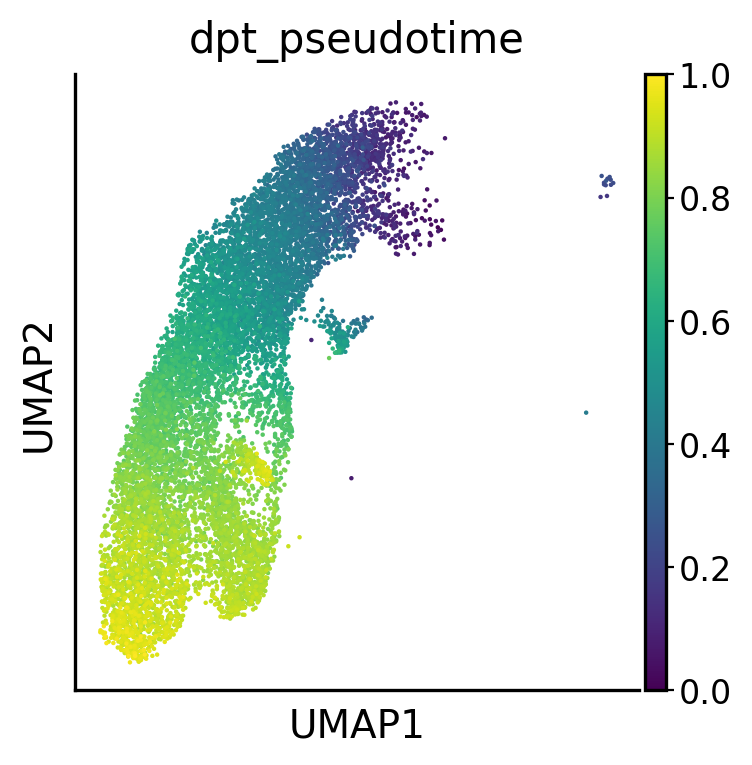

In [10]:
sc.tl.diffmap(mudata)
sc.tl.dpt(mudata)
sc.pl.embedding(
    mudata,
    basis="umap",
    color=["dpt_pseudotime"],
)

In [11]:
adata = mudata["rna"]
adata.obs = mudata.obs.copy()
adata.obsm = mudata.obsm.copy()
adata.obsp = mudata.obsp.copy()

In [12]:
adata.obs["cell_type"] = adata.obs["cell_type"].cat.remove_unused_categories()



In [13]:
pk = cellrank.kernels.PseudotimeKernel(adata, time_key="dpt_pseudotime")
pk.compute_transition_matrix(threshold_scheme='soft', b=12.0, nu=0.75, check_irreducibility=True, frac_to_keep=0.5)

100%|███████████████████████████████████████████████████████████████████████| 11645/11645 [00:05<00:00, 2298.37cell/s]


PseudotimeKernel[n=11645, dnorm=False, scheme='soft', b=12.0, nu=0.75]

In [14]:
g = cellrank.estimators.GPCCA(pk)

In [15]:
g.fit(cluster_key="cell_type", n_states=15)

GPCCA[kernel=PseudotimeKernel[n=11645], initial_states=None, terminal_states=None]

In [16]:
g.macrostates.cat.categories

Index(['Ngn3 high cycling', 'Ngn3 low_1', 'Beta_1', 'Epsilon_1', 'Delta',
       'Ngn3 high_1', 'Alpha', 'Fev+ Alpha', 'Epsilon_2', 'Ngn3 low_2',
       'Beta_2', 'Ngn3 low_3', 'Ngn3 high_2', 'Fev+ Beta', 'Ngn3 high_3'],
      dtype='object')

In [17]:
g.set_terminal_states(states=["Alpha", "Beta_1", "Epsilon_1", "Delta"])

GPCCA[kernel=PseudotimeKernel[n=11645], initial_states=None, terminal_states=['Alpha', 'Beta_1', 'Delta', 'Epsilon_1']]

In [18]:
g.compute_fate_probabilities()

Defaulting to `'gmres'` solver.


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75/s]


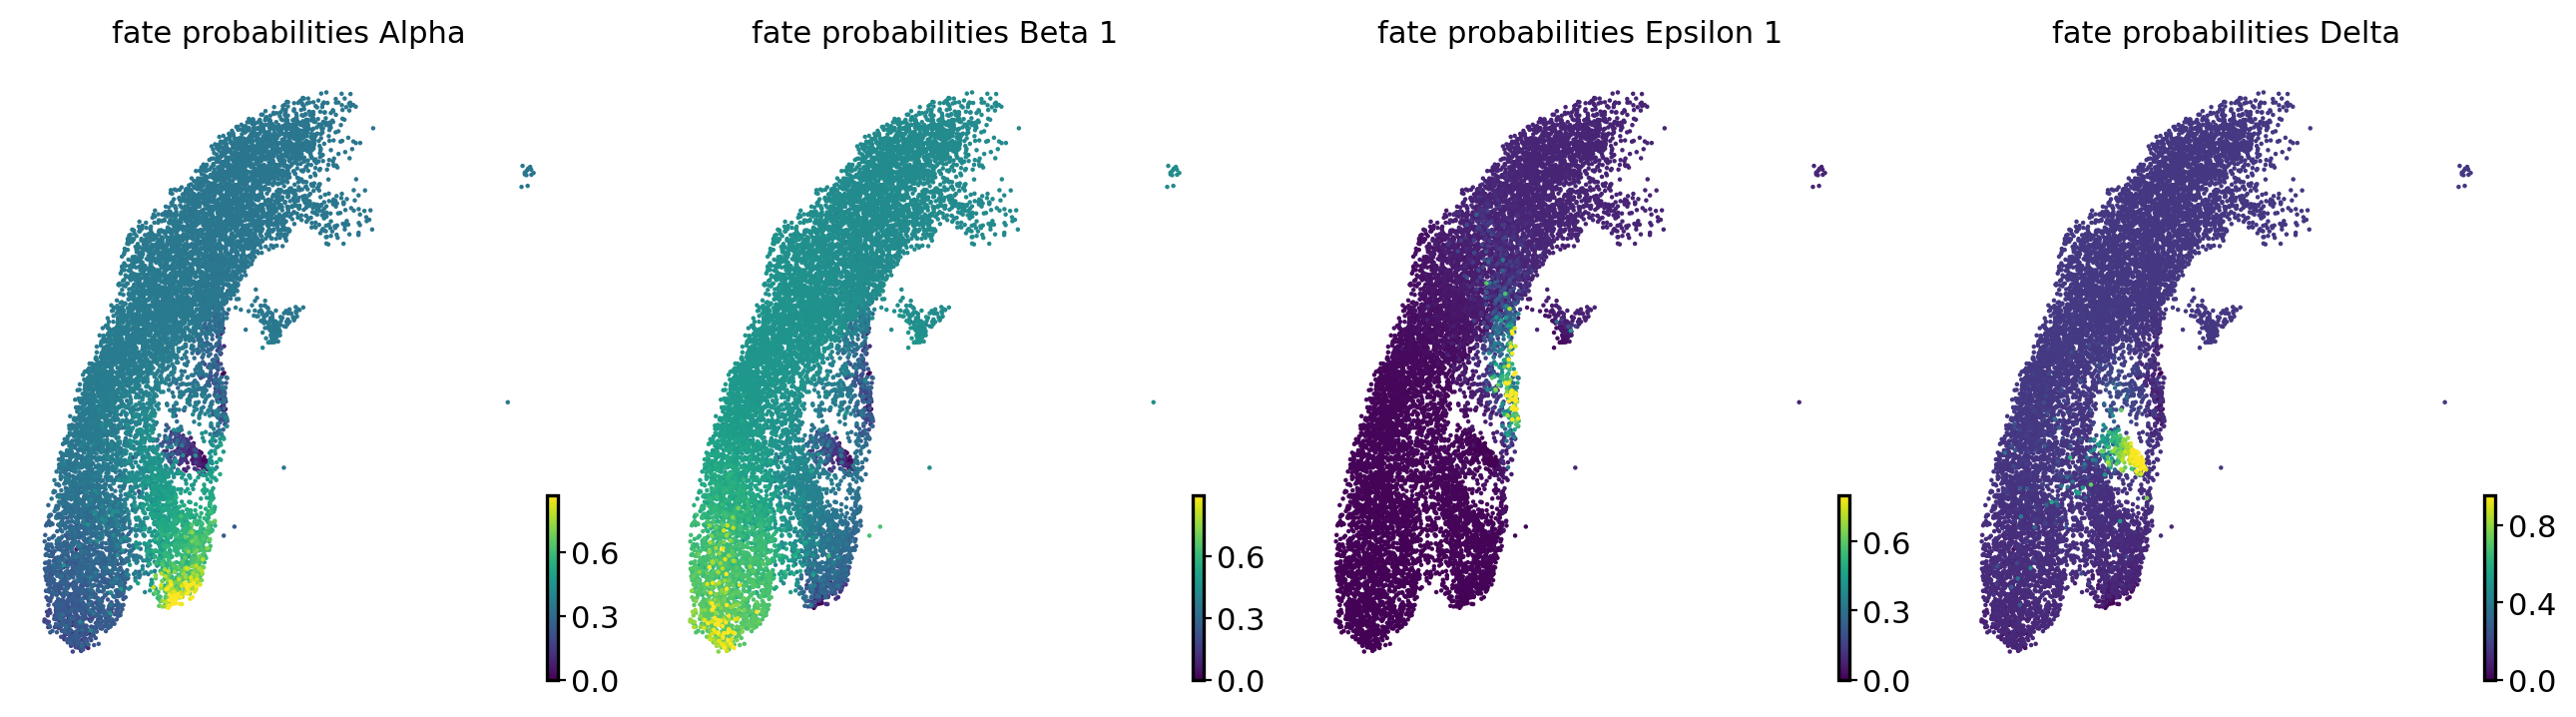

In [19]:
g.plot_fate_probabilities(same_plot=False)

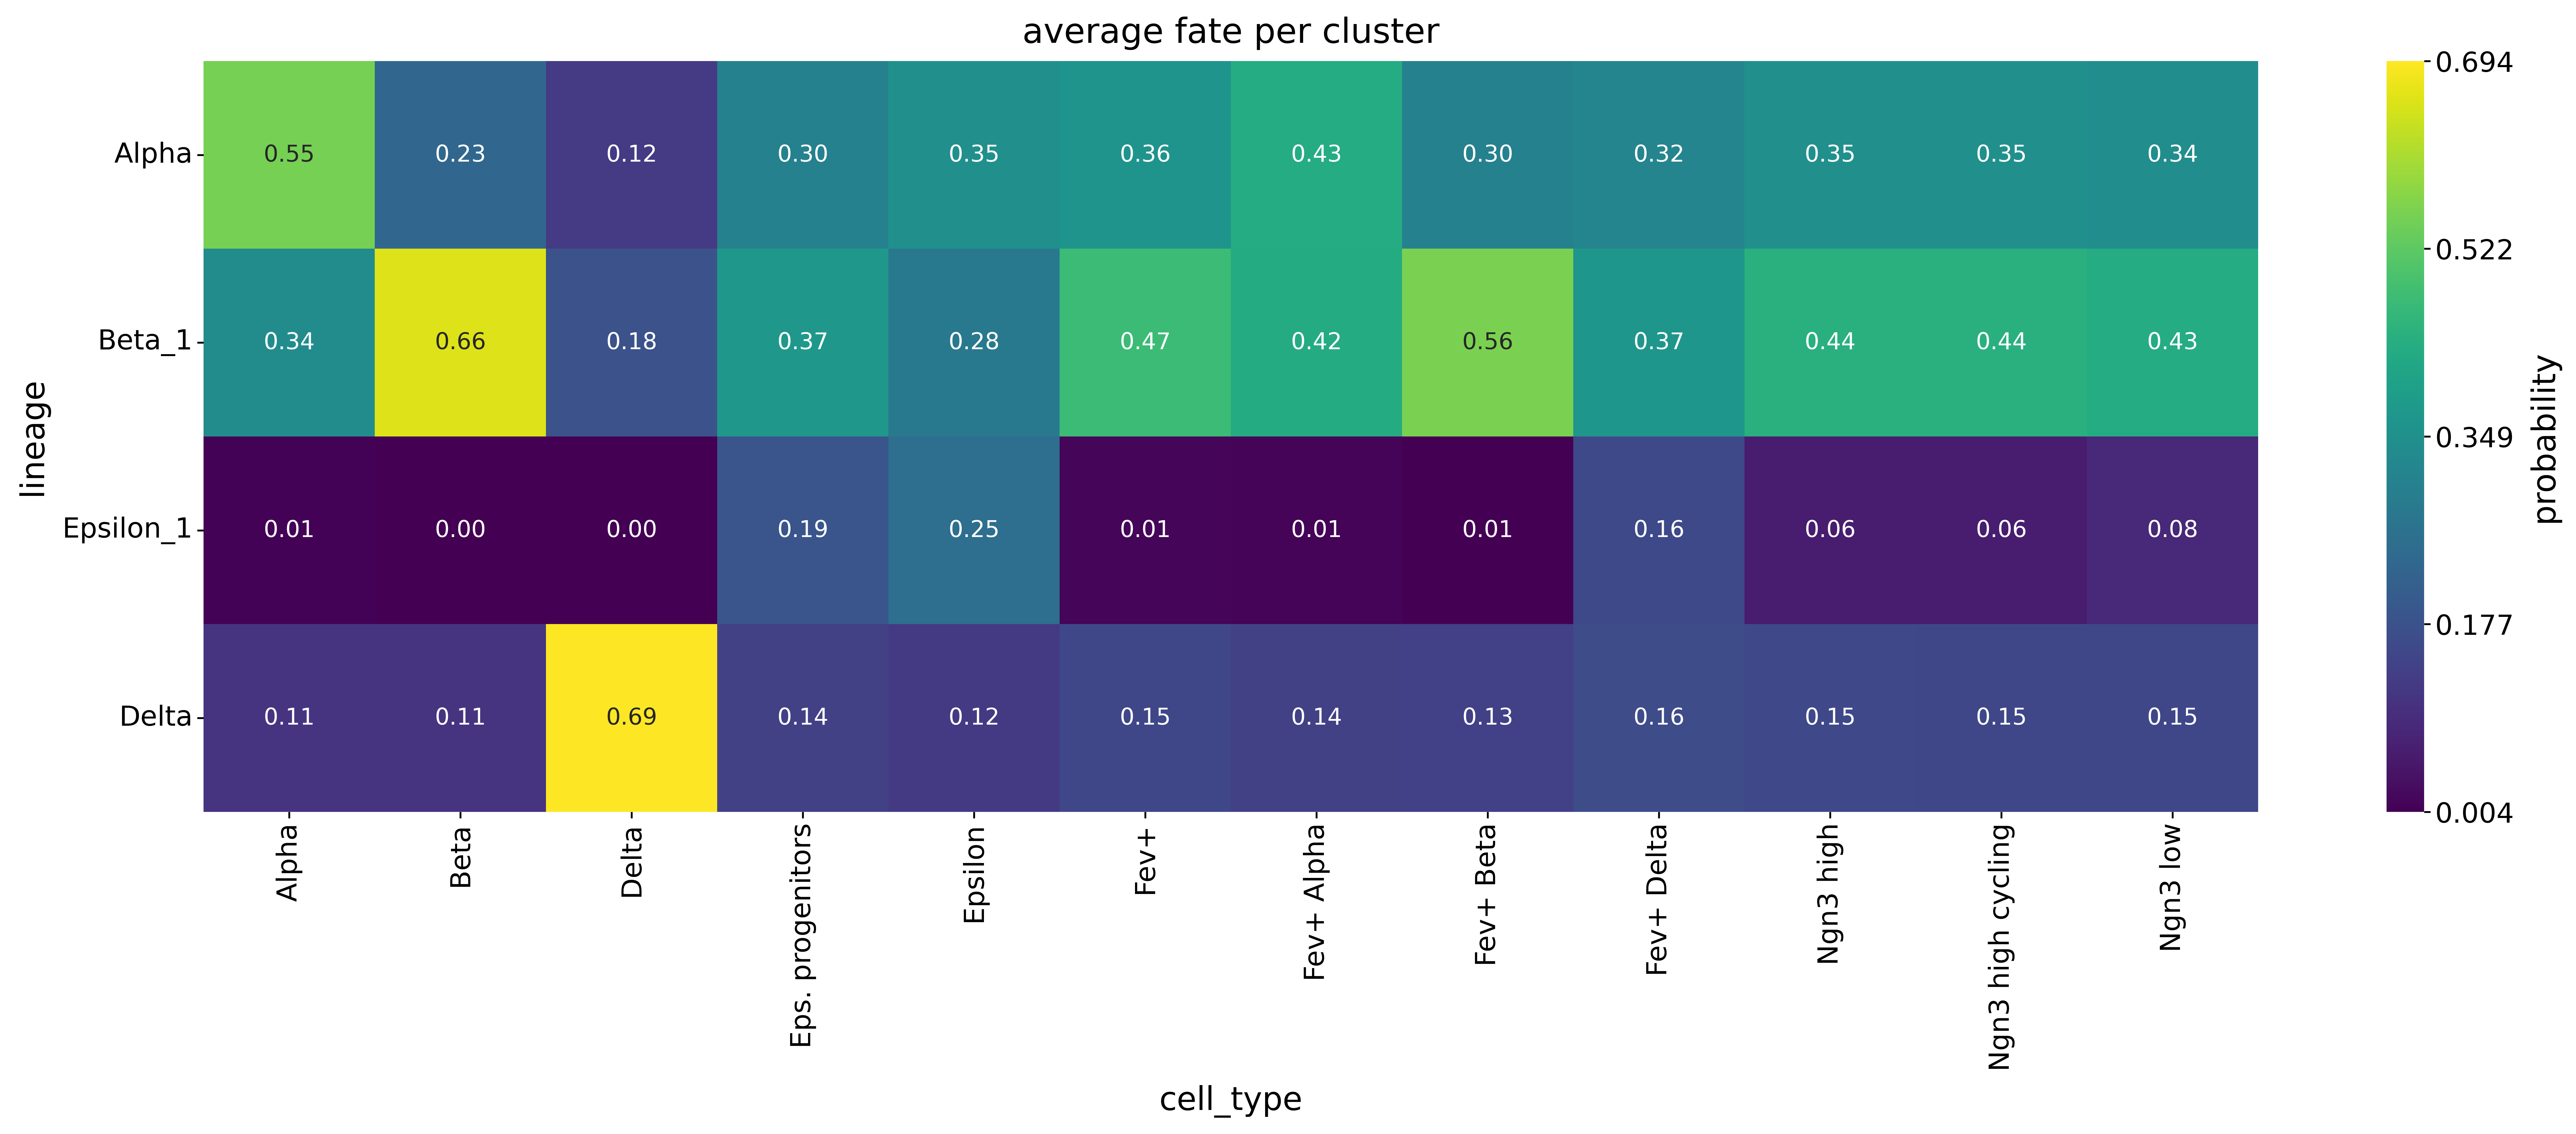

In [68]:
cellrank.pl.aggregate_fate_probabilities(
        adata=adata,
        mode='heatmap',
        lineages=["Alpha", "Beta_1", "Epsilon_1", "Delta"],
        cluster_key="cell_type",
        clusters=None,
        figsize=(20, 6),
        dpi=300,
    )